# 基于抱抱脸🦌DDPM

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda:1'
print(f'Using device: {device}')

Using device: cuda:1


# 准备数据集
蝴蝶数据集

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([9, 2, 3, 0, 9, 8, 1, 3])


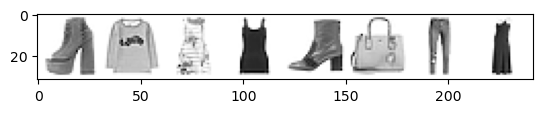

In [2]:
dataset = torchvision.datasets.FashionMNIST(root="famnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# 加噪方案
DDPM的加噪方案，这里不详细记录

因为fashion比较简单，所以前向后向过程就设置了40步

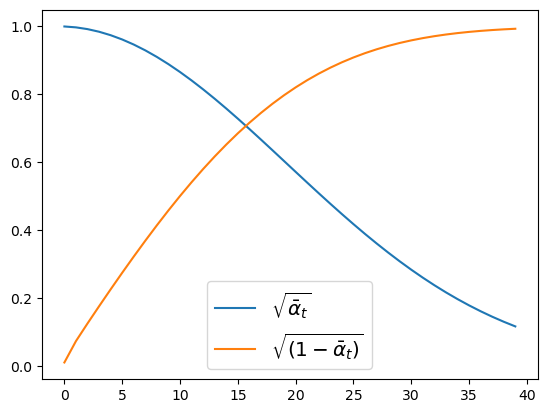

In [3]:
num_steps = 40

from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=40, beta_start=0.0001, beta_end=0.2)  # 
# noise_scheduler = DDPMScheduler(num_train_timesteps=num_steps)

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

# 模型

In [4]:
# 从抱抱脸拿了一个Unet
# 输入是加噪图片(n,c,h,w)，及时间步长(n,)
# 输出是预测噪声(n,c,h,w)

from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=(28,28),  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [5]:
# 参数量统计

sum([p.numel() for p in model.parameters()])

12980481

## 训练策略   
按照DDPM的算法

In [6]:
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# How many runs through the data should we do?
n_epochs = 20
# Create the network
net = model
net.to(device)

net.eval()
# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

from tqdm import tqdm

# The training loop
for epoch in range(n_epochs):

    for x,y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise = torch.randn(x.shape).to(x.device)
        # rand是在0-1之间获取随机数，即获取n个随机加噪程度
        timesteps = torch.randint(low=0, high=num_steps, size=(x.shape[0],)).long().to(device)
        # 获取n个加噪后的图片
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # 模型去噪
        # print(noisy_x.shape)
        # print(noise_amount.shape)
        # 输入加噪图片与步长
        # 返回噪声预测
        pred = net(noisy_x.to(device), timesteps, return_dict=False)[0]

        # 计算损失mse
        loss = loss_fn(pred, noise.to(device)) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.ylim(0, 1)

100%|██████████| 469/469 [01:08<00:00,  6.89it/s]


Finished epoch 0. Average loss for this epoch: 0.076179


100%|██████████| 469/469 [01:05<00:00,  7.13it/s]


Finished epoch 1. Average loss for this epoch: 0.049556


100%|██████████| 469/469 [01:05<00:00,  7.11it/s]


Finished epoch 2. Average loss for this epoch: 0.045402


100%|██████████| 469/469 [01:05<00:00,  7.13it/s]


Finished epoch 3. Average loss for this epoch: 0.043239


100%|██████████| 469/469 [01:05<00:00,  7.13it/s]


Finished epoch 4. Average loss for this epoch: 0.042149


100%|██████████| 469/469 [01:22<00:00,  5.69it/s]


Finished epoch 5. Average loss for this epoch: 0.041533


100%|██████████| 469/469 [01:44<00:00,  4.49it/s]


Finished epoch 6. Average loss for this epoch: 0.040617


100%|██████████| 469/469 [01:36<00:00,  4.85it/s]


Finished epoch 7. Average loss for this epoch: 0.039872


100%|██████████| 469/469 [01:53<00:00,  4.14it/s]


Finished epoch 8. Average loss for this epoch: 0.039248


100%|██████████| 469/469 [01:54<00:00,  4.10it/s]


Finished epoch 9. Average loss for this epoch: 0.039283


100%|██████████| 469/469 [01:50<00:00,  4.25it/s]


Finished epoch 10. Average loss for this epoch: 0.038634


 48%|████▊     | 223/469 [00:48<00:53,  4.56it/s]


KeyboardInterrupt: 

## 采样策略  
严格按照DDPM原文的sampling写的

/tmp/ipykernel_794678/43134634.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)


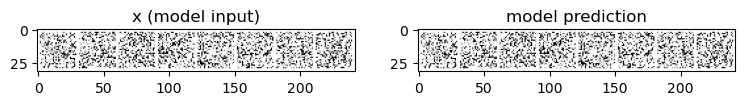

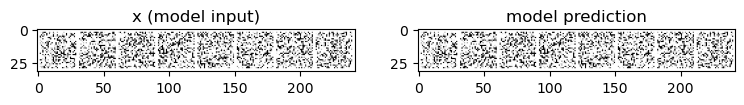

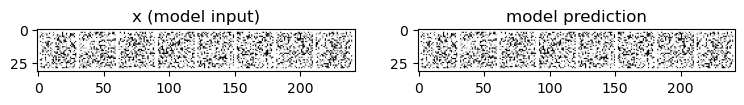

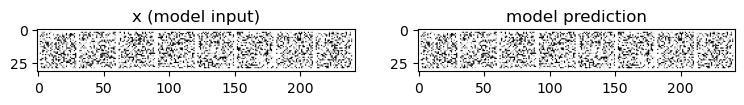

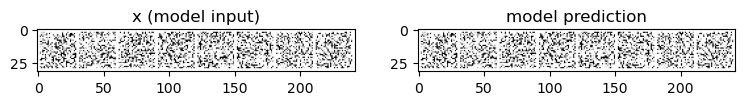

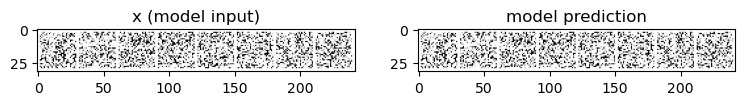

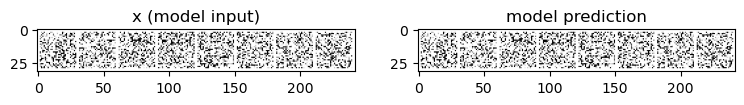

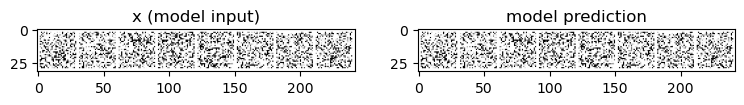

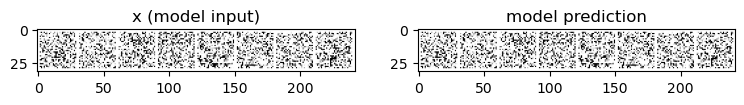

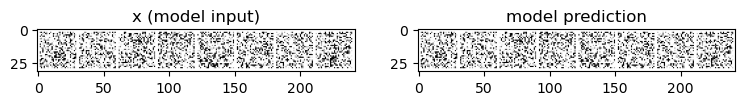

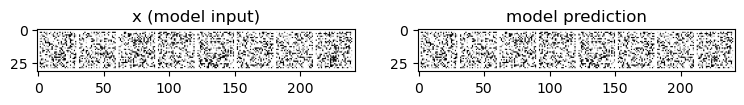

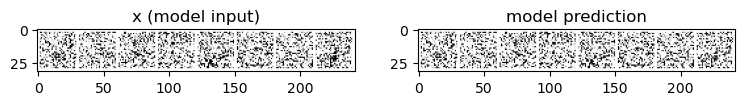

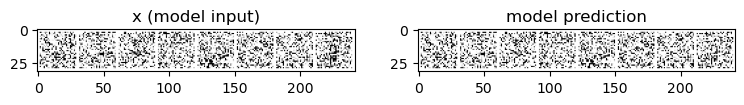

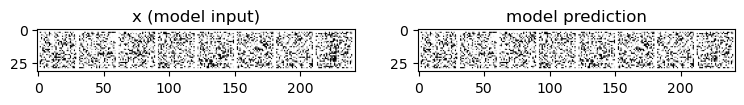

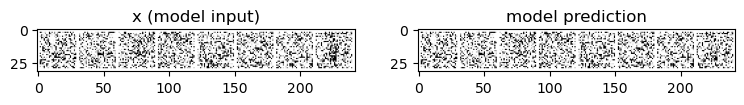

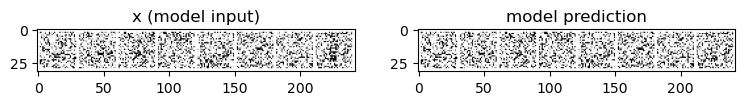

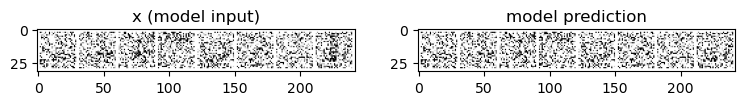

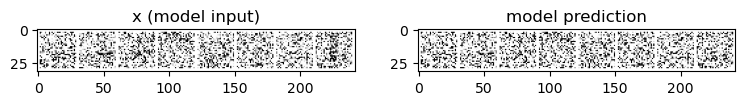

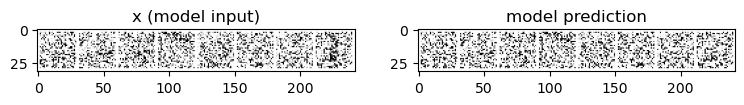

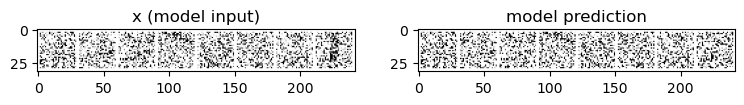

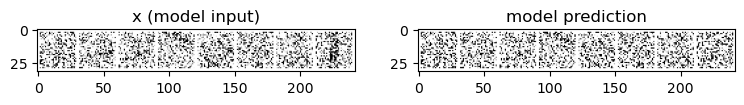

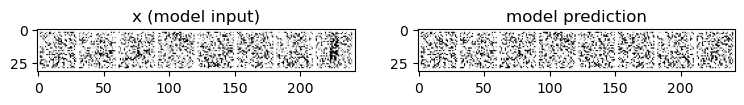

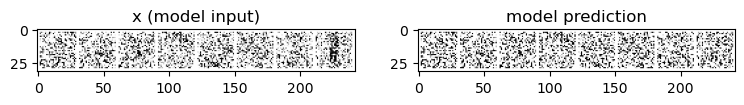

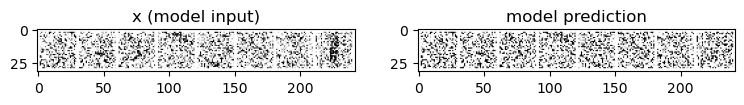

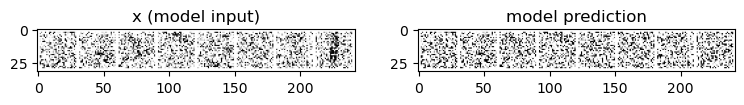

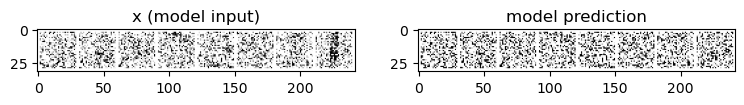

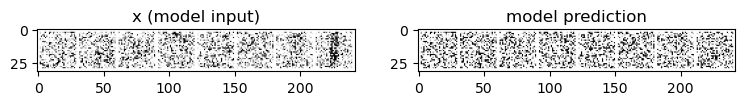

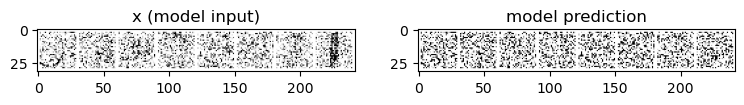

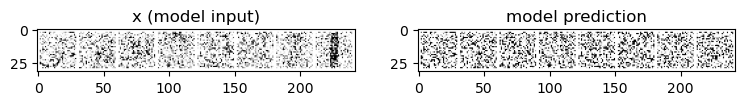

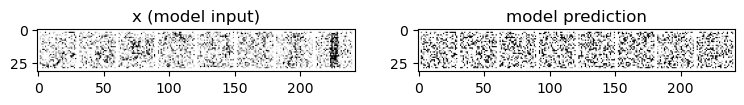

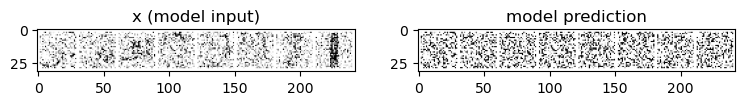

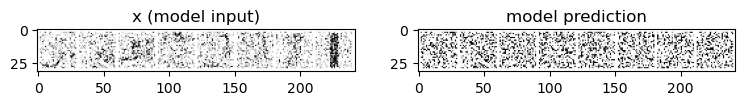

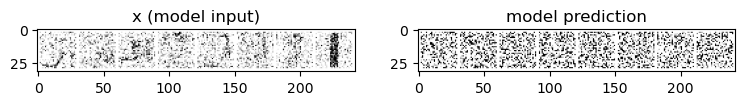

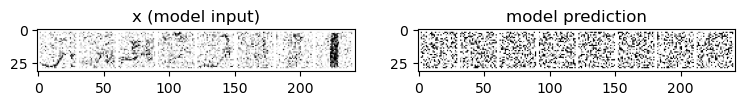

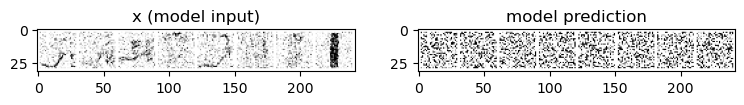

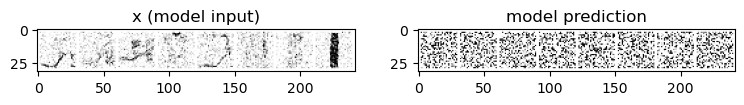

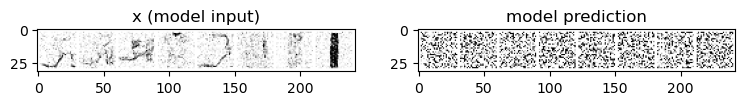

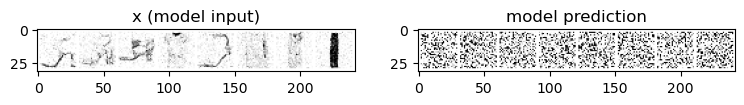

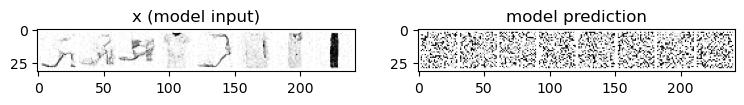

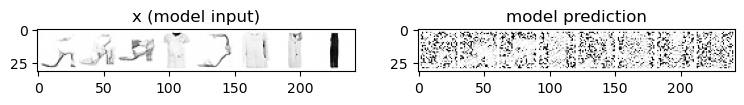

In [9]:
sample = torch.randn(8, 1, 28, 28).to(device) 
step_history = [sample.detach().cpu()]
pred_output_history = []

for t in noise_scheduler.timesteps:  
    with torch.no_grad(): 
        residual = model(sample, t).sample
        sample = noise_scheduler.step(residual, t, sample).prev_sample
        pred_output_history.append(residual.detach().cpu())
        step_history.append(sample.detach().cpu()) # Store step for plotting


for i in range(n_steps):
    fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True)
    axs[0].set_title('x (model input)')
    axs[1].set_title('model prediction')
    axs[0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap='Greys')
    axs[1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap='Greys')

  0%|          | 0/40 [00:00<?, ?it/s]

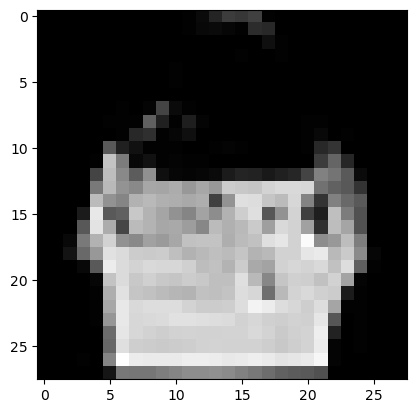

In [29]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

pipeline_output = image_pipe(num_inference_steps=40)
# x = torchvision.transforms.ToTensor()(pipeline_output.images[0])
import matplotlib.pyplot as plt
plt.imshow(pipeline_output.images[0], cmap='gray')  # 对于灰度图，使用灰度颜色映射
plt.show()


nb，入门diffusion